# Implementation of Improving Language Understanding by Generative Pre-Training

## GPT from Transformer Decoder
### 3.1 Unsupervised pre-training
  - We use **a multi-layer Transformer decoder** for the language model, which is a variant of the transformer.
  - This model applies a multi-headed self-attention operation over the input context tokens followed by **position-wise feedforward layers** to produce an output distribution over target tokens.
  - h0 = UWe + Wp
  - hl = transformer_block(hl−1)∀i ∈ [1, n]
  - P(u) = softmax(hn WeT)
  
#### Todos:
  ![transformer_removed](./images/transformer_removed.png)
  1. Take only decoder part code.
  2. Modify from positional encoding to text & position embedding.
  3. Modify the linked part code between encoder and decoder.
  4. Remove the padding mask. (Auto-Regressive)
  
#### Completed architecture form
  ![gpt](./images/gpt.png)

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

# Multi-Head Attention
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

In [4]:
#########################
# 2. 포지셔널 인코딩 레이어 -> Text & position embedding Layer
#########################
# class PositionalEncoding(tf.keras.layers.Layer):
class TextPostionEmbeddingLayer(tf.keras.layers.Layer):

  def __init__(self, vocab_size, d_model, max_position=512):
    super(TextPostionEmbeddingLayer, self).__init__()
    self.token_embedding = tf.keras.layers.Embedding(vocab_size, d_model)
    self.position_embedding = tf.keras.layers.Embedding(max_position, d_model)  # ✅ 학습 가능한 위치 임베딩
    self.d_model = d_model

  def call(self, inputs):
    seq_length = tf.shape(inputs)[1]
    positions = tf.range(start=0, limit=seq_length, delta=1)
    
    position_embeddings = self.position_embedding(positions)
    token_embeddings = self.token_embedding(inputs)
    
    return token_embeddings + position_embeddings

In [5]:
#########################
# Decoder
#########################
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  # 마스크
  #########################
  # 4. Remove the padding mask. (Auto-Regressive)
  #########################
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + inputs)

  #########################
  # 3. Modify the linked part code between encoder and decoder.
  #########################
  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  # --> 디코더만 사용하기 때문에 인코더와 연결 부분인 해당 두 번째 서브 레이어를 삭제

  # 세 번째 서브 레이어 : 2개의 완전연결층 --> Feed Forward Network (FFN)
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention)

  return tf.keras.Model(
      inputs=[inputs, look_ahead_mask],
      outputs=outputs,
      name=name)

In [6]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            max_position=512,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')

  # 마스크
  #########################
  # 4. Remove the padding mask. (Auto-Regressive)
  #########################
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  #########################
  # 2. Modify from positional encoding to text & position embedding.
  #########################
  embeddings = TextPostionEmbeddingLayer(
      vocab_size, 
      d_model, 
      max_position=max_position
  )(inputs)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, look_ahead_mask])

  return tf.keras.Model(
      inputs=[inputs, look_ahead_mask],
      outputs=outputs,
      name=name)

## GPT Pretraining
#### Loss function
  - The inputs are passed through our pre-trained model to obtain the final transformer block’s activation hml , which is then fed into an added linear output layer with parameters Wy to predict y:
    - P(y|x1,...,xm) = softmax(hml Wy)
  - We optimize the following objective (with weight λ)
    - L3(C) = L2(C) + λ ∗ L1(C)
    - L1(U) = Sigma(logP(ui|ui−k,...,ui−1;Θ))
    - L2(C) = Sigma(logP(y|x1,...,xm))
    
#### Todos:
1. Add pretraining.
2. Add output.
3. Modify Look ahead mask function.

In [7]:
#########################
# 3. Modify Look ahead mask function.
#########################
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  # 룩어헤드 마스크
  # return 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  return tf.linalg.band_part(tf.ones((1, 1, seq_len, seq_len)), -1, 0)

In [ ]:
def gpt(vocab_size,
        num_layers,
        units,
        d_model,
        num_heads,
        dropout,
        name="gpt"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(inputs)

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, look_ahead_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs], outputs=outputs, name=name)

## Data preprocessing

In [10]:
import os
import pandas as pd

datapath = os.getenv('HOME')+'/aiffel/transformer_chatbot/data/ChatbotData.csv'
data = pd.read_csv(datapath)
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [11]:
import re

# 전처리 함수
def preprocess_sentence(sentence):
  # 단어와 구두점(punctuation) 사이의 공백 추가
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  # 연속된 공백을 하나의 공백으로 전환
  sentence = re.sub(r'[" "]+', " ", sentence)
  sentence = sentence.strip()
  return sentence

In [12]:
data['clean_q'] = data['Q'].apply(lambda x : preprocess_sentence(x))
data['clean_a'] = data['A'].apply(lambda x : preprocess_sentence(x))

In [13]:
data.head()

,Q,A,label,clean_q,clean_a
0,12시 땡!,하루가 또 가네요.,0,12시 땡 !,하루가 또 가네요 .
1,1지망 학교 떨어졌어,위로해 드립니다.,0,1지망 학교 떨어졌어,위로해 드립니다 .
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .
4,PPL 심하네,눈살이 찌푸려지죠.,0,PPL 심하네,눈살이 찌푸려지죠 .


In [14]:
questions = data['clean_q']
answers = data['clean_a']

**토크나이저 수정..**

In [15]:
import tensorflow_datasets as tfds

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN, DELIM_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1], [tokenizer.vocab_size + 2]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 3
VOCAB_SIZE = tokenizer.vocab_size + 3

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])
print('DELIM_TOKEN 번호 :' ,[tokenizer.vocab_size + 2])
print('단어장의 크기 :',VOCAB_SIZE)

START_TOKEN의 번호 : [8364]
END_TOKEN의 번호 : [8365]
DELIM_TOKEN 번호 : [8366]
단어장의 크기 : 8367


In [16]:
START_TOKEN, END_TOKEN, DELIM_TOKEN

([8364], [8365], [8366])

In [ ]:
import tensorflow as tf

# 최대 길이를 40으로 정의
MAX_LENGTH = 40

def tokenize_and_filter(inputs, outputs):
  tokenized = []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + DELIM_TOKEN
    sentence2 = tokenizer.encode(sentence2) + END_TOKEN
    
    tokenized.append(sentence1 + sentence2)

  # 패딩
  tokenized = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized, maxlen=MAX_LENGTH, padding='post')

  return tokenized

In [18]:
preprocessed = tokenize_and_filter(questions, answers)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용
# 이에 따라 outputs에서는 START_TOKEN을 제거
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': preprocessed[:, :-1] # 마지막 패딩 토큰 제거
    },
    {
        'outputs': preprocessed[:, 1:]  # 시작 토큰이 제거
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

**토크나이저 수정 여기까지..**

### Models

In [20]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
VOCAB_SIZE = 32000
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
# NUM_LAYERS = 6
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
# D_MODEL = 768
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

gpt = gpt(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

gpt.summary()

Model: "gpt"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (1, 1, None, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
decoder (Functional)            (None, None, 256)    9377280     inputs[0][0]                     
                                                                 look_ahead_mask[0][0]            
__________________________________________________________________________________________________
outputs (Dense)                 (None, None, 32000)  8224000     decoder[0][0]                  

In [22]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [23]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [24]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

gpt.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [25]:
checkpoint_path = os.getenv('HOME') + "/aiffel/transformer_chatbot/data/gpt1_checkpoint"
os.makedirs(checkpoint_path, exist_ok=True)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor="loss",
    mode="min"
)

In [29]:
EPOCHS = 50
history = gpt.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 32s 94ms/step - loss: 3.3842 - accuracy: 0.0226
Epoch 2/50
185/185 [==============================] - 17s 95ms/step - loss: 2.7432 - accuracy: 0.0518
Epoch 3/50
185/185 [==============================] - 18s 96ms/step - loss: 2.2634 - accuracy: 0.0809
Epoch 4/50
185/185 [==============================] - 18s 97ms/step - loss: 1.8572 - accuracy: 0.1006
Epoch 5/50
185/185 [==============================] - 18s 99ms/step - loss: 1.3741 - accuracy: 0.1608
Epoch 6/50
185/185 [==============================] - 19s 100ms/step - loss: 0.9149 - accuracy: 0.2324
Epoch 7/50
185/185 [==============================] - 18s 100ms/step - loss: 0.5608 - accuracy: 0.2992
Epoch 8/50
185/185 [==============================] - 18s 99ms/step - loss: 0.3066 - accuracy: 0.3356
Epoch 9/50
185/185 [==============================] - 18s 99ms/step - loss: 0.1366 - accuracy: 0.3412
Epoch 10/50
185/185 [==============================] - 18s 100ms/step - loss: 0.

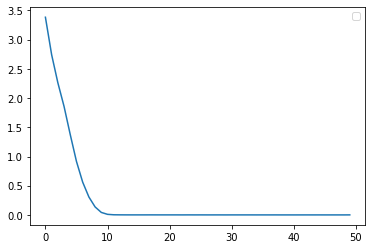

In [30]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.legend()
plt.show()

In [43]:
def decoder_inference(sentence, custom_model):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 Delimeter 토큰을 앞뒤로 추가.
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence), axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(DELIM_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = custom_model(inputs=[sentence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [44]:
def sentence_generation(sentence, custom_model):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴
  prediction = decoder_inference(sentence, custom_model)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}\n'.format(predicted_sentence))

  return predicted_sentence

In [45]:
sentence_generation('아 심심해', gpt)

입력 : 아 심심해
출력 : 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 



'걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 걸 '